In [52]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [45]:
stocks = pd.read_csv('stocks_filtered.csv')
stocks['date'] = pd.to_datetime(stocks['date'])
stocks = stocks.set_index('date')


In [78]:
stocks.sort_values('date')

,ticker,adj_close
date,,
2017-12-01,GOOG,50.508500
2017-12-01,AMZN,57.977862
2017-12-01,AAPL,40.542754
2017-12-01,NVDA,48.957940
2017-12-01,MSFT,79.231484
...,...,...
2023-06-30,MSFT,340.540000
2023-06-30,AMZN,130.360000
2023-06-30,NVDA,423.020000


# Time series of stock prices

In [46]:
stocks_pivot = pd.pivot_table(stocks, index = stocks.index,
                              columns = "ticker", values = "adj_close")

stocks_pivot.isna().sum()

ticker
AAPL    0
AMZN    0
GOOG    0
MSFT    0
NVDA    0
dtype: int64

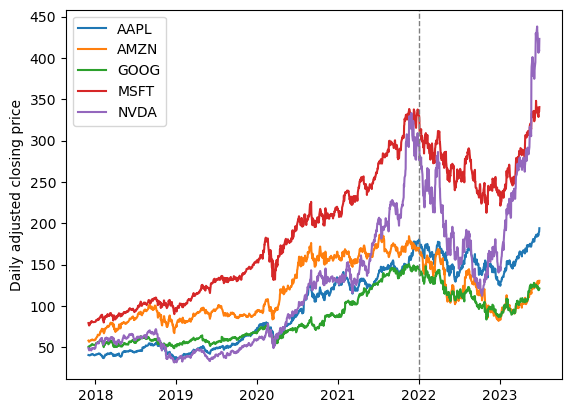

In [77]:
for ticker in stocks_pivot.columns:
    plt.plot(stocks_pivot.index, stocks_pivot[ticker], label = ticker)

plt.axvline(x=pd.to_datetime('2022-01-01'), color='gray', lw=1, ls="--")
plt.legend(loc="upper left")

plt.ylabel('Daily adjusted closing price')

plt.savefig('timeseries.png')

# Auto- and partial auto-correlation

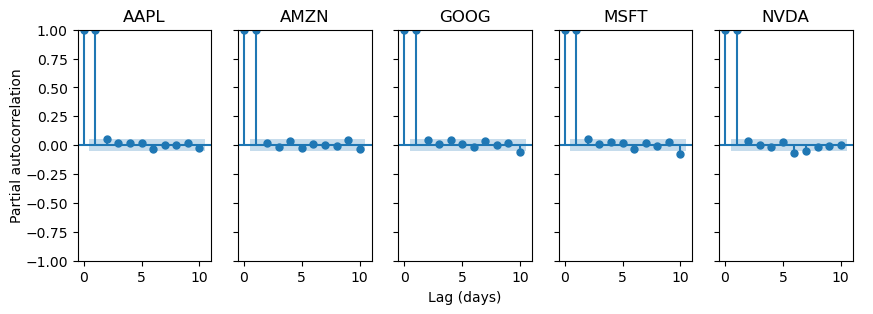

In [106]:
import statsmodels.api as sm

fig, ax = plt.subplots(1, 5, figsize=(10,3), 
                       sharex=True, sharey=True)

for ticker,i in zip(stocks_pivot.columns, range(5)):
    
    sm.graphics.tsa.plot_pacf(stocks_pivot[ticker],lags=10, ax=ax[i])
    ax[i].set_title(ticker)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)



plt.ylabel('Partial autocorrelation\n')
plt.xlabel('Lag (days)')


plt.savefig('PACF.png')

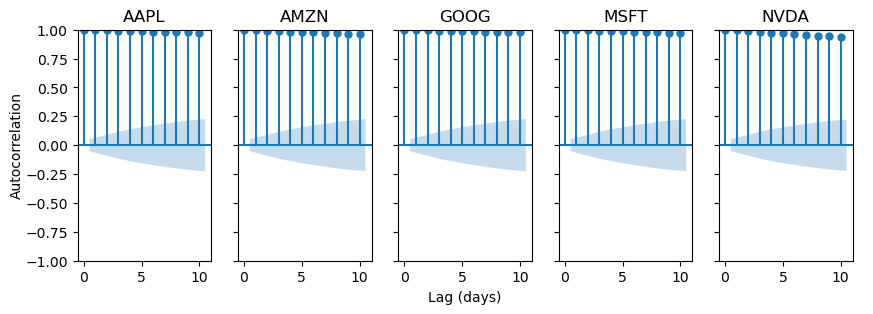

In [110]:
fig, ax = plt.subplots(1, 5, figsize=(10,3), 
                       sharex=True, sharey=True)

for ticker,i in zip(stocks_pivot.columns, range(5)):
    
    sm.graphics.tsa.plot_acf(stocks_pivot[ticker],lags=10, ax=ax[i])
    ax[i].set_title(ticker)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)



plt.ylabel('Autocorrelation\n')
plt.xlabel('Lag (days)')

plt.savefig('ACF.png')

# Sentiment analysis

In [151]:
sentiment = pd.read_csv('daily_sentiment.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'])

# lets aggregate across month
sentiment['date'] = sentiment['date'].apply(lambda ts: ts.replace(day=1))

monthly_sentiment = sentiment.drop(columns=['neg', 'neu', 'pos']).groupby(
    ['date', 'ticker']
).agg({'compound' : 'mean',
       'volume' : 'sum'}).reset_index().set_index('date')

In [162]:
monthly_compound = pd.pivot_table(monthly_sentiment, index = monthly_sentiment.index,
               columns = "ticker", values = "compound")

monthly_vol = pd.pivot_table(monthly_sentiment, index = monthly_sentiment.index,
               columns = "ticker", values = "volume")

# remove july 2023 because not representative
monthly_compound = monthly_compound[:-1]
monthly_vol = monthly_vol[:-1]


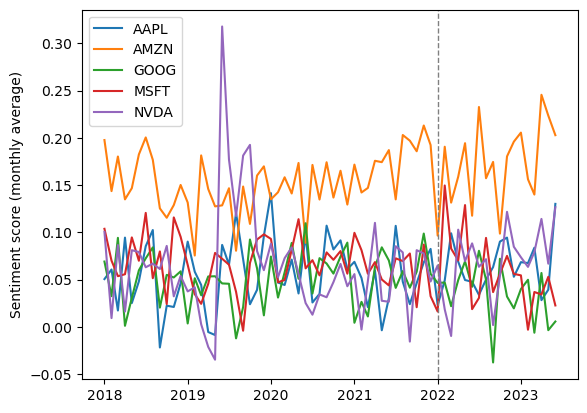

In [177]:
for ticker in monthly_compound.columns:
    plt.plot(monthly_compound.index, monthly_compound[ticker], label = ticker)

plt.axvline(x=pd.to_datetime('2022-01-01'), color='gray', lw=1, ls="--")
plt.legend(loc="upper left")

plt.ylabel('Sentiment score (monthly average)')

plt.savefig('monthlysentiment.png')

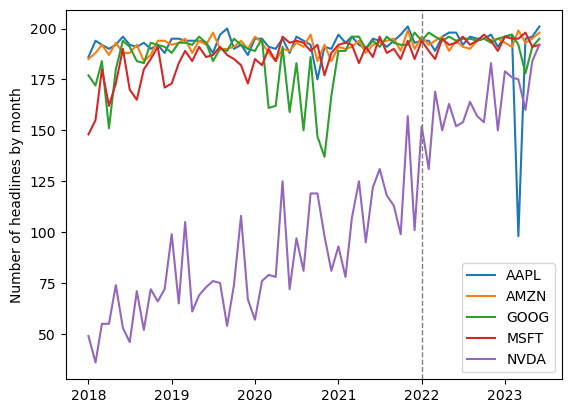

In [178]:
for ticker in monthly_vol.columns:
    plt.plot(monthly_vol.index, monthly_vol[ticker], label = ticker)

plt.axvline(x=pd.to_datetime('2022-01-01'), color='gray', lw=1, ls="--")
plt.legend(loc="lower right")

plt.ylabel('Number of headlines by month')

plt.savefig('monthlyvol.png')

In [158]:
monthly_compound

ticker,AAPL,AMZN,GOOG,MSFT,NVDA
date,,,,,
2018-01-01,0.050525,0.197604,0.069083,0.103705,0.100452
2018-02-01,0.060657,0.143608,0.032447,0.070039,0.009267
2018-03-01,0.017292,0.180219,0.094147,0.053611,0.086505
2018-04-01,0.094396,0.134861,0.001120,0.055652,0.016178
2018-05-01,0.025155,0.146663,0.030604,0.094614,0.081101
...,...,...,...,...,...
2023-03-01,0.083727,0.139943,-0.006206,0.036877,0.079033
2023-04-01,0.028234,0.245505,0.056974,0.034201,0.114199
2023-05-01,0.039274,0.223496,-0.003524,0.052905,0.066840


In [ ]:
sentiment = sentiment.set_index('date')

Text(0.5, 0, 'Sentiment score (daily average)')

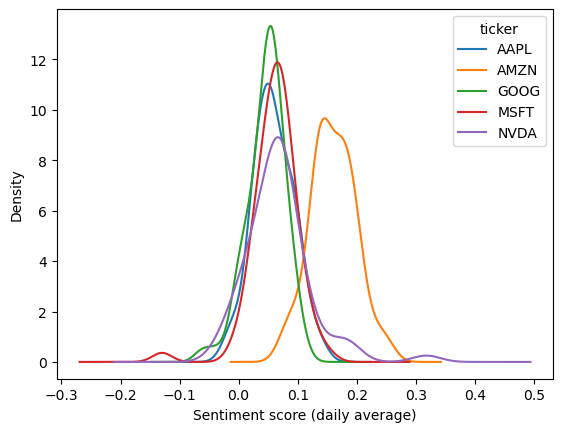

In [179]:
pd.pivot_table(sentiment, index=sentiment.index,
               columns='ticker', values='compound').plot(kind='density')

plt.xlabel('Sentiment score (daily average)')

In [201]:
from scipy.stats import gaussian_kde


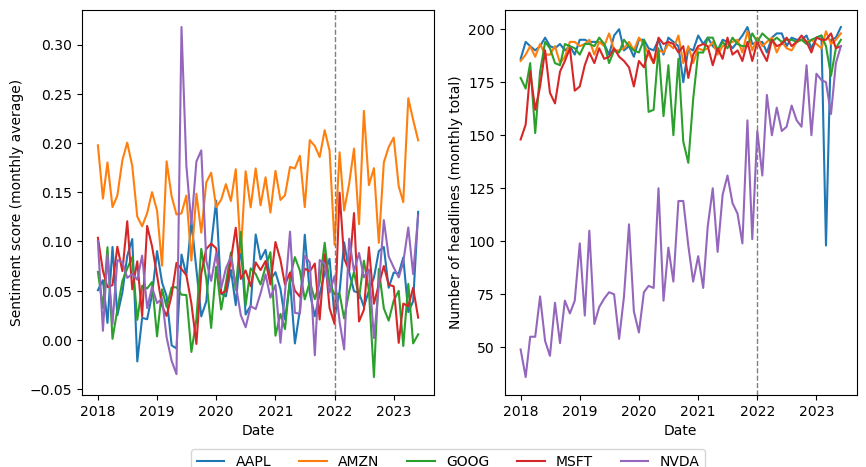

In [249]:
fix, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)

for ticker in monthly_compound.columns:
    ax[0].plot(monthly_compound.index, monthly_compound[ticker], label = ticker)

ax[0].axvline(x=pd.to_datetime('2022-01-01'), color='gray', lw=1, ls="--")
ax[0].set(ylabel="Sentiment score (monthly average)", xlabel='Date')

for ticker in monthly_vol.columns:
    ax[1].plot(monthly_vol.index, monthly_vol[ticker], label = ticker)

ax[1].axvline(x=pd.to_datetime('2022-01-01'), color='gray', lw=1, ls="--")
ax[1].set(ylabel="Number of headlines (monthly total)", xlabel='Date')

ax[1].legend(labels, loc='lower center', bbox_to_anchor=(0.7,-0.03), 
           ncol=len(labels), bbox_transform=fig.transFigure)

plt.savefig('sentiment_timeseries.png', bbox_inches="tight")

In [203]:
density

In [205]:
labels

['AAPL', 'AMZN', 'GOOG', 'MSFT', 'NVDA']

[Text(0.5, 0, 'Sentiment score (daily average)'), Text(0, 0.5, 'Density')]

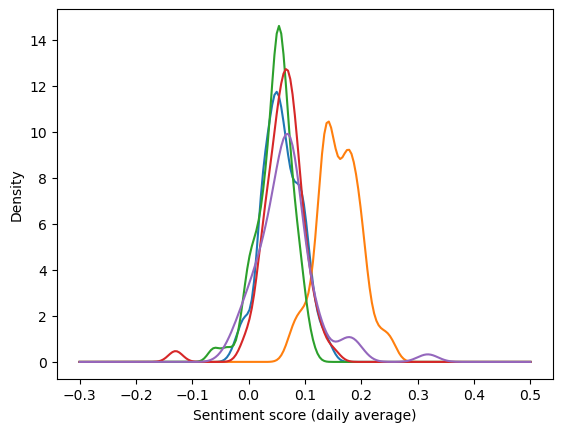

In [237]:
fig, ax = plt.subplots()

sentiment_pivot = pd.pivot_table(sentiment, index=sentiment.index,
               columns='ticker', values='compound')

for ticker in sentiment_pivot.columns:
    density = gaussian_kde(sentiment_pivot[ticker])
    xs = np.linspace(-0.3,0.5,200)
    density.covariance_factor = lambda : .33
    density._compute_covariance()
    ax.plot(xs, density(xs))

ax.set(xlabel='Sentiment score (daily average)', ylabel='Density')